In [1]:
import os

import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.spatial import cKDTree
from shapely.geometry import Point, Polygon

import contextily as ctx
from iteround import saferound

In [2]:
path_dir = r"C:\Users\USYS671257\OneDrive - WSP O365\21_31000110.002_Chattanooga TPO Model\1-density_plot"

## Read in the Buildings
Download Microsoft Buildings layer: https://github.com/microsoft/USBuildingFootprints


In [5]:
states = ['Tennessee', 'Georgia']

bldgs_raw = []

for s in states:
    print('Processing Buildings in {}'.format(s))
    bldgs_load = gpd.read_file(os.path.join(path_dir, "Buildings", s, f"{s}.geojson"))
    print('Total {} {:,d}'.format(s, len(bldgs_load)))
    bldgs_raw.append(bldgs_load)
    
bldgs_raw = pd.concat(bldgs_raw, sort=True).reset_index(drop=True)

bldgs = bldgs_raw.copy()
bldgs['geometry'] = bldgs['geometry'].centroid
bldgs['X'] = bldgs.geometry.x
bldgs['Y'] = bldgs.geometry.y

bldgs= bldgs[(bldgs['X'].between(-85.592898, -84.905851)) & (bldgs['Y'].between(34.738912, 35.591059))].copy()

print('Number of buildings in bbox {:,d}'.format(len(bldgs)))

Processing Buildings in Tennessee
Total Tennessee 3,002,503
Processing Buildings in Georgia
Total Georgia 3,873,560
Number of buildings in bbox 260,845


## Get the TAZID onto the Buildings

In [6]:
# Simply Method to Expedite the Spatial Joins
def spatial_index_join(polygon_layer, point_layer, polygon_field, fuzzy_match=False):
    counter = 0
    pt_layer = point_layer.copy()

    for poly in polygon_layer.itertuples():
        counter = counter + 1
        if counter % 100 == 0:
            print('Processing {}: {}'.format(polygon_field, counter))
        bounds = poly.geometry.bounds
        possible_matches = pt_layer[(pt_layer['X'].between(bounds[0], bounds[2])) & (pt_layer['Y'].between(bounds[1], bounds[3]))].copy()
        if fuzzy_match:
            pt_layer.loc[possible_matches.index, polygon_field] = getattr(poly, polygon_field)
        else:
            idx = possible_matches[possible_matches.geometry.intersects(poly.geometry)].index
            pt_layer.loc[idx, polygon_field] = getattr(poly, polygon_field)
        
    return pt_layer

In [8]:
# base year TAZ file with SED inputs
zone = gpd.read_file(os.path.join(path_dir, "TAZ", "2014.shp"))
taz = zone[['TAZID', 'geometry']][zone['geometry'].is_valid].copy()
taz = taz.to_crs(bldgs.crs)

bldgs = spatial_index_join(taz, bldgs, 'TAZID')
bldgs = bldgs[~bldgs['TAZID'].isnull()].copy()

Processing TAZID: 100
Processing TAZID: 200
Processing TAZID: 300
Processing TAZID: 400
Processing TAZID: 500
Processing TAZID: 600
Processing TAZID: 700


In [9]:
# Prepare Buildings
dtypes = {
    'X': np.float,
    'Y': np.float,
    'TAZID': str,
}

bldgs = bldgs[dtypes.keys()]

## Assign Nearest CARTA Station to Building

In [10]:
# Calculate Distances to Stations
from math import radians, cos, sin, asin, sqrt

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [row.X, row.Y, row.stop_lon, row.stop_lat])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956  # Radius of earth in miles. Use 6371 for km
    return c * r

In [11]:
stations = pd.read_csv(os.path.join(path_dir, "CARTA", "gtfs", "stops.txt"))

bldg_locs = np.array(bldgs[['X', 'Y']])
station_locs = np.array(stations[['stop_lon', 'stop_lat']])

btree = cKDTree(station_locs)
dist, idx = btree.query(bldg_locs, k=1)

bldgs = pd.concat([bldgs.reset_index(drop=True),
                   stations.loc[idx, ['stop_id', 'stop_name', 'stop_lon','stop_lat']].reset_index(drop=True),
                  ], axis=1)

bldgs['chatt_dist'] = bldgs.apply(haversine, axis=1)
bldgs = bldgs.drop(columns=['stop_lon', 'stop_lat']).rename(columns={'stop_name': 'chatt_stop', 'stop_id': 'chatt_id'})

## Assign a Probability for Each Building (grouped by TAZ)

In [12]:
# Calculate Dispersion
dispersion = -0.5
bldgs['chatt_utility'] = np.exp(dispersion * bldgs['chatt_dist'])

In [13]:
# Calculate Percentage Likelihood
bldgs['chatt_pct'] = bldgs.groupby('TAZID')['chatt_utility'].apply(lambda x: x / x.sum())
bldgs = bldgs.reset_index().rename(columns={'index':'ID'})
bldgs['ID'] = bldgs['ID'] + 1

## Assign Population and Employment to Buildings

In [14]:
sed = zone[["TAZID","TOTPOP","TOTAL_EMP"]].fillna(0)
bldgs = bldgs.merge(sed, on="TAZID", how="left")
bldgs["pop"] = bldgs["TOTPOP"]*bldgs["chatt_pct"]
bldgs["emp"] = bldgs["TOTAL_EMP"]*bldgs["chatt_pct"]

In [15]:
# round pop and emp and maintain their sums
taz_list = bldgs["TAZID"].unique()

for t in taz_list:
    for col in ["pop","emp"]:
        subset = bldgs[bldgs["TAZID"]==t][col]
        subset = saferound(subset, places=0)
        bldgs.loc[bldgs["TAZID"]==t,col] = subset

In [16]:
bldgs.head()

,ID,X,Y,TAZID,chatt_id,chatt_stop,chatt_dist,chatt_utility,chatt_pct,TOTPOP,TOTAL_EMP,pop,emp
0,1,-85.170336,35.445042,632.0,562,N POINT BLVD + OWEN CYCLERY,21.558422,0.000021,0.013092,78.0,0.0,1.0,0.0
1,2,-85.168026,35.441142,632.0,562,N POINT BLVD + OWEN CYCLERY,21.320085,0.000023,0.014749,78.0,0.0,1.0,0.0
2,3,-85.084794,35.443434,1035.0,562,N POINT BLVD + OWEN CYCLERY,22.879071,0.000011,0.002601,0.0,0.0,0.0,0.0
3,4,-85.086633,35.444518,1035.0,562,N POINT BLVD + OWEN CYCLERY,22.907573,0.000011,0.002564,0.0,0.0,0.0,0.0
4,5,-85.082326,35.445353,1035.0,562,N POINT BLVD + OWEN CYCLERY,23.055585,0.000010,0.002381,0.0,0.0,0.0,0.0


## Make Dot Density Plot

In [17]:
# Randomly Generating Points within Polygons
# https://github.com/agaidus/census_data_extraction/blob/master/census_mapper.py

from numpy.random import RandomState, uniform

def gen_random_points_poly(poly, num_points, seed = None):
    """
    Returns a list of N randomly generated points within a polygon. 
    """
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i=0
    while len(points) < num_points:
        s=RandomState(seed+i) if seed else RandomState(seed)
        random_point = Point([s.uniform(min_x, max_x), s.uniform(min_y, max_y)])
        if random_point.within(poly):
            points.append(random_point)
        i+=1
    return points


def gen_points_in_gdf_polys(geometry, values, points_per_value = None, seed = None):
    """
    Take a GeoSeries of Polygons along with a Series of values and returns randomly generated points within
    these polygons. Optionally takes a "points_per_value" integer which indicates the number of points that 
    should be generated for each 1 value.
    """
    if points_per_value:
        new_values = (values/points_per_value).astype(int)
    else:
        new_values = values
    new_values = new_values[new_values>0]
    g = gpd.GeoDataFrame(data = {'vals':new_values}, geometry = geometry)
    
    a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'], seed)),1)
    b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
    b.name='geometry'
    return b

In [18]:
# prepare taz layer
taz = taz.to_crs(epsg=3857)

# prepare taz boundary
taz_geo = taz["geometry"]
union = gpd.GeoSeries(taz_geo.unary_union)

# prepare dot layer
bldgs_gdf = gpd.GeoDataFrame(bldgs, geometry=gpd.points_from_xy(bldgs["X"], bldgs["Y"]),crs=bldgs_raw.crs)
bldgs_gdf = bldgs_gdf.to_crs(epsg=3857)
bldgs_gdf["geometry"]=bldgs_gdf.buffer(20)

In [19]:
def make_dot_den_plot(var, color, title):
    # prepare dot layer
    random_points = gen_points_in_gdf_polys(geometry = bldgs_gdf["geometry"], values=bldgs_gdf[var])

    # make plot
    fig, ax = plt.subplots(1,1,figsize=(40,20))

    random_points.plot(ax=ax, marker='.', color=color, markersize=0.01, zorder=4)
    union.plot(ax=ax,color='none',edgecolor='black', zorder=3)
    taz.plot(ax=ax, color='none', edgecolor='darkgrey', zorder=2)
    ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite, alpha=.4, zorder=1, attribution_size=4)

    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.annotate(title, 
                xy=(.15, .97), xycoords='axes fraction', horizontalalignment='center', fontsize = 18)
    ax.annotate("1 dot = 1 people", 
                xy=(.15, .95), xycoords='axes fraction', horizontalalignment='center', fontsize = 14)

    plt.show()
    # plt.savefig(os.path.join(path_dir + "{title}.png"), dpi=300)
    # plt.close(fig)

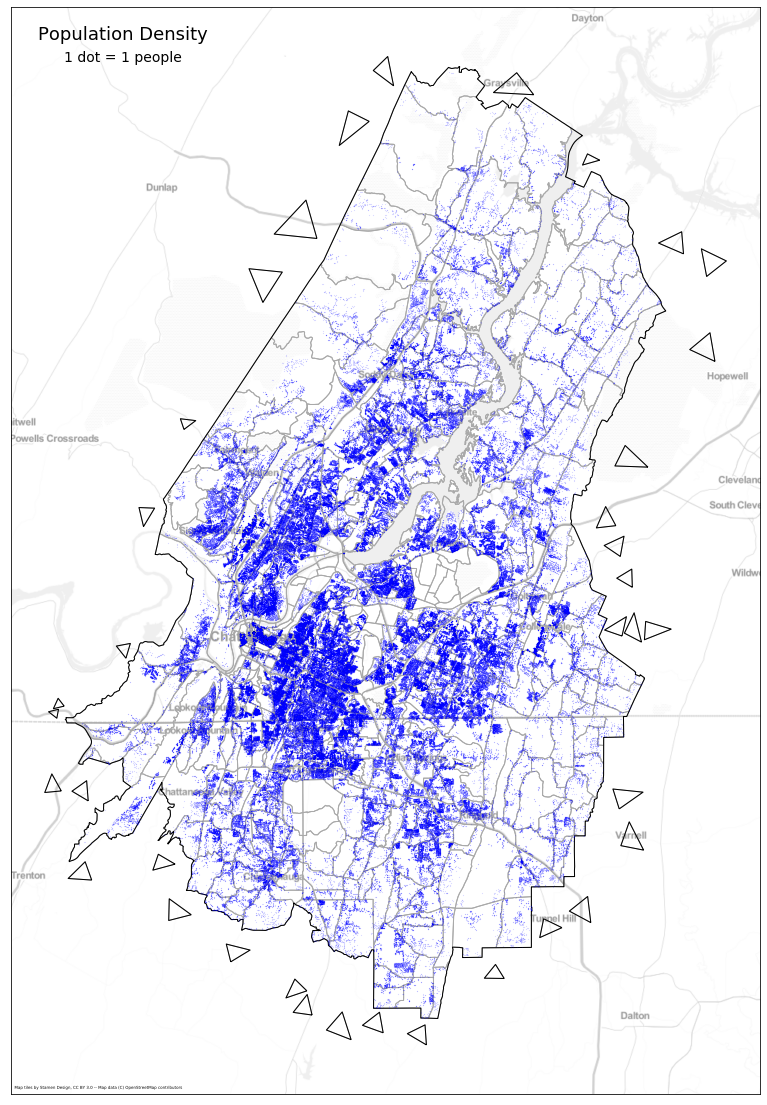

In [20]:
make_dot_den_plot("pop","blue","Population Density")

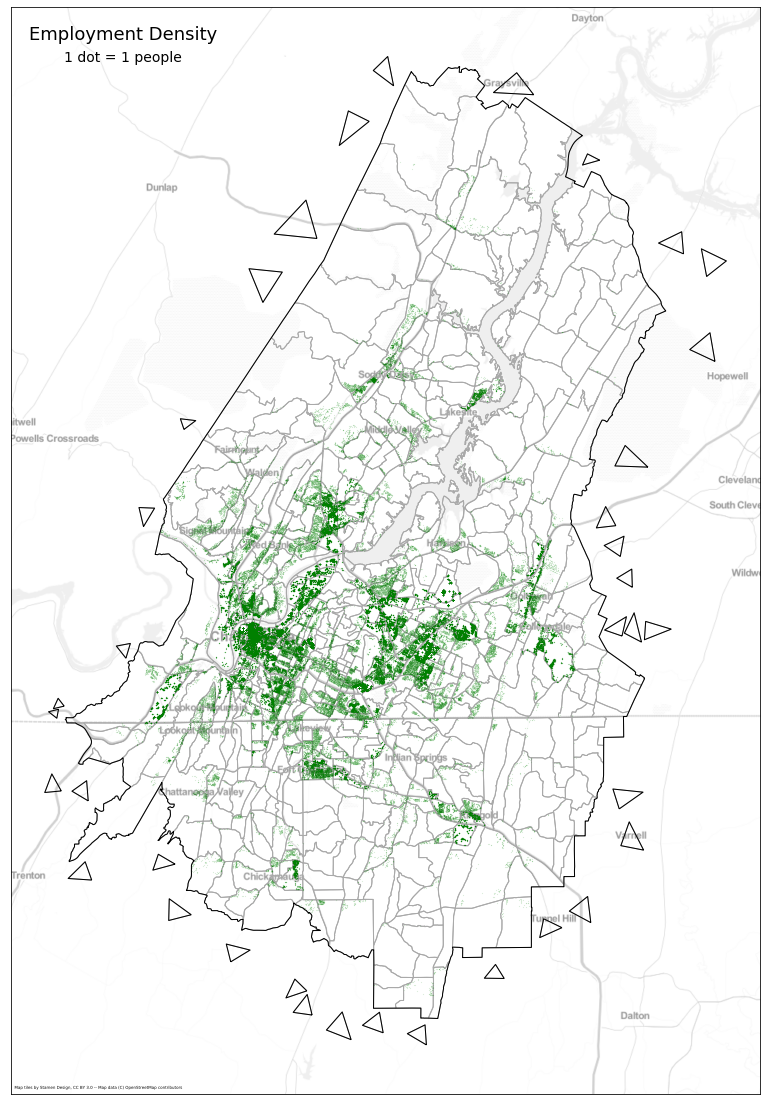

In [21]:
make_dot_den_plot("emp","green","Employment Density")